In [53]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [54]:
import pathlib
data_dir = pathlib.Path("../dataset_images")

In [55]:
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.bmp')))
print(image_count)

6048


In [56]:
batch_size = 32
scale_down = 1
img_width = int(160 / scale_down)
img_height = int(120 / scale_down)

colour_mode = "rgb"

validation_split = 0.1

seed = 123

class_names = [ "value_0", "value_1", "value_2", "value_3", "value_4", "value_5", "value_6", "value_7", "value_8", "value_9", "value_10", "value_11", "value_12", "value_13", "value_14", "value_15", "value_16", "value_17", "value_18", "value_19", "value_20", "value_21", "value_22", "value_23", "value_24", "value_25", "value_26", "value_27", "value_28", "value_29", "value_30", "value_31", "value_32", "value_33", "value_34", "value_35", "value_36", "value_37", "value_38", "value_39"]

In [57]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  class_names=class_names,
  color_mode=colour_mode,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6048 files belonging to 40 classes.
Using 5444 files for training.


In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  class_names=class_names,
  color_mode=colour_mode,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6048 files belonging to 40 classes.
Using 604 files for validation.


In [59]:
class_names = train_ds.class_names
print(class_names)

['value_0', 'value_1', 'value_2', 'value_3', 'value_4', 'value_5', 'value_6', 'value_7', 'value_8', 'value_9', 'value_10', 'value_11', 'value_12', 'value_13', 'value_14', 'value_15', 'value_16', 'value_17', 'value_18', 'value_19', 'value_20', 'value_21', 'value_22', 'value_23', 'value_24', 'value_25', 'value_26', 'value_27', 'value_28', 'value_29', 'value_30', 'value_31', 'value_32', 'value_33', 'value_34', 'value_35', 'value_36', 'value_37', 'value_38', 'value_39']


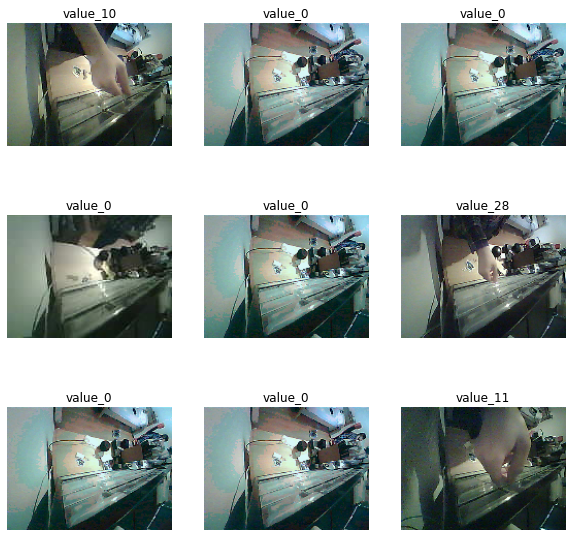

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [61]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [62]:
num_classes = len(class_names)

factor = 0.25

model = Sequential([
  # layers.GaussianNoise(stddev=0.02, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(factor * 8, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(),
  # layers.Conv2D(factor * 6, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Conv2D(factor * 4, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Conv2D(factor * 2, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(2 * num_classes, activation='relu'),
  layers.Dense(num_classes)
])

In [63]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 120, 160, 2)       56        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 60, 80, 2)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 80, 1)         19        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 40, 1)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 40, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 80)               

In [65]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [66]:
epochs=28
history = model.fit(
  normalized_train_ds,
  validation_data=normalized_val_ds,
  epochs=epochs
)

==============] - 17s 101ms/step - loss: 0.1486 - accuracy: 0.9517 - val_loss: 0.2628 - val_accuracy: 0.9272
Epoch 26/160
171/171 [==============================] - 18s 103ms/step - loss: 0.1325 - accuracy: 0.9552 - val_loss: 0.2708 - val_accuracy: 0.9288
Epoch 27/160
171/171 [==============================] - 18s 103ms/step - loss: 0.1513 - accuracy: 0.9513 - val_loss: 0.2818 - val_accuracy: 0.9139
Epoch 28/160
171/171 [==============================] - 17s 101ms/step - loss: 0.1390 - accuracy: 0.9522 - val_loss: 0.2879 - val_accuracy: 0.9288
Epoch 29/160
171/171 [==============================] - 18s 102ms/step - loss: 0.1261 - accuracy: 0.9570 - val_loss: 0.2902 - val_accuracy: 0.9288
Epoch 30/160
171/171 [==============================] - 17s 101ms/step - loss: 0.1184 - accuracy: 0.9567 - val_loss: 0.2687 - val_accuracy: 0.9255
Epoch 31/160
171/171 [==============================] - 17s 101ms/step - loss: 0.1158 - accuracy: 0.9642 - val_loss: 0.2406 - val_accuracy: 0.9437
Epoch 32/

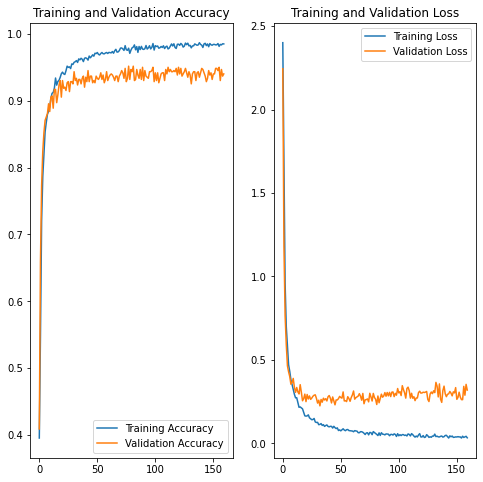

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
def representative_dataset():
  for image_batch, labels_batch in normalized_train_ds:
    yield [image_batch]


In [69]:
model_with_softmax = tf.keras.Sequential([model, layers.Softmax()])

converter = tf.lite.TFLiteConverter.from_keras_model(model_with_softmax)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]



tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/1q/_vlxftdn3gn_h6kg3ty1b2jr0000gn/T/tmp7_jt5yl4/assets
INFO:tensorflow:Assets written to: /var/folders/1q/_vlxftdn3gn_h6kg3ty1b2jr0000gn/T/tmp7_jt5yl4/assets


In [70]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

In [71]:
  
import re
import hexdump
def outputTFLModel(tflite_model, variable_name='model_data', pretty_print=False):
    bytes = hexdump.dump(tflite_model).split(' ')
    c_array = ', '.join(['0x%02x' % int(byte, 16) for byte in bytes])
    c = 'const unsigned char %s[] DATA_ALIGN_ATTRIBUTE = {%s};' % (variable_name, c_array)
    if pretty_print:
        c = c.replace('{', '{\n\t').replace('}', '\n}')
        c = re.sub(r'(0x..?, ){12}', lambda x: '%s\n\t' % x.group(0), c)
    c += '\nconst int %s_len = %d;' % (variable_name, len(bytes))
    preamble = '''
// if having troubles with min/max, uncomment the following
// #undef min    
// #undef max
#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif
'''
    return preamble + c

In [72]:

# from tinymlgen import port
# c_code = port(model, pretty_print=False, optimize=True)
c_code = outputTFLModel(tflite_quant_model)
print(c_code)

, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00, 0xfc, 0xf4, 0xff, 0xff, 0x14, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x80, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x80, 0x3b, 0x0d, 0x00, 0x00, 0x00, 0x49, 0x64, 0x65, 0x6e, 0x74, 0x69, 0x74, 0x79, 0x5f, 0x69, 0x6e, 0x74, 0x38, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00, 0xb0, 0xf4, 0xff, 0xff, 0x00, 0x00, 0x00, 0x09, 0xb4, 0x00, 0x00, 0x00, 0x11, 0x00, 0x00, 0x00, 0x54, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00, 0x94, 0xf4, 0xff, 0xff, 0x30, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x

In [73]:
src_dir = pathlib.Path("../src")
model_file = open(src_dir / "model.h", "w")
model_file.write(c_code)
model_file.close()

In [74]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'sequential_4_input', 'index': 18, 'shape': array([  1, 120, 160,   3], dtype=int32), 'shape_signature': array([ -1, 120, 160,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 19, 'shape': array([ 1, 40], dtype=int32), 'shape_signature': array([-1, 40], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [75]:
input_shape = input_details[0]['shape']
print(input_details)

[{'name': 'sequential_4_input', 'index': 18, 'shape': array([  1, 120, 160,   3], dtype=int32), 'shape_signature': array([ -1, 120, 160,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


<TakeDataset shapes: ((None, 120, 160, 3), (None,)), types: (tf.float32, tf.int32)>


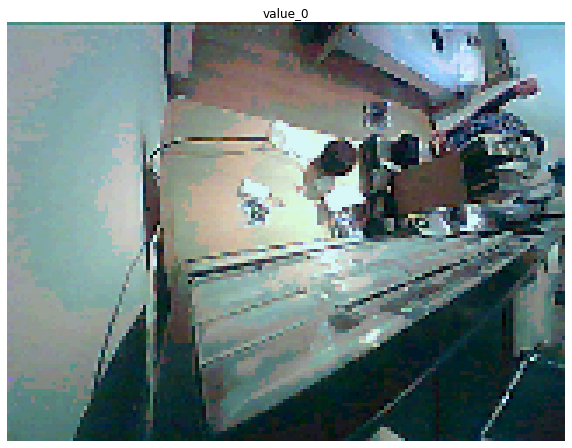

In [76]:
real_input = 0
print(normalized_val_ds.take(1))
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  plt.imshow(images[0].numpy().astype("uint8"))
  real_input = images[0].numpy().astype("float32") / 255
  plt.title(class_names[labels[0]])
  plt.axis("off")
interpreter.set_tensor(input_details[0]['index'], [real_input])

In [77]:
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.99609375 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]


In [78]:
np.where(output_data[0] == np.max(output_data[0]))


(array([0]),)